# ColabでJuliaを使うためのノートブック v0.3

このノートブックの内容については再配布・改変・部分的コピーその他すべてを自由に行って構いません。

このノートブックは[Google Colabで実行できる](https://colab.research.google.com/github/genkuroki/public/blob/main/0054/Julia%20notebook%20for%20Google%20Colab%20v0.3.ipynb).

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

import Pkg

"""すでにPkg.add済みのパッケージのリスト (高速化のために用意)"""
_packages_added = [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if !(pkg in _packages_added)
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd begin
using Distributions
using StatsPlots
using QuadGK: quadgk
using Roots: find_zero, find_zeros
using SymPy: SymPy, sympy, @syms, oo
end

In [2]:
(@macroexpand @autoadd using A) |> Base.remove_linenums!

quote
    Main.add_pkg_if_not_added_yet.(["A"])
    using A
end

In [3]:
(@macroexpand @autoadd using A, B, C) |> Base.remove_linenums!

quote
    Main.add_pkg_if_not_added_yet.(["A", "B", "C"])
    using A, B, C
end

In [4]:
(@macroexpand @autoadd using A: a1, a2, @a3) |> Base.remove_linenums!

quote
    Main.add_pkg_if_not_added_yet.(["A"])
    using A: a1, a2, @a3
end

In [5]:
(@macroexpand @autoadd begin
using A: a1
using A.B
using A.C: c1, c2
#using D
using E, A.F, G
using H: h1, h2
using I
end) |> Base.remove_linenums!

quote
    Main.add_pkg_if_not_added_yet.(["A", "E", "G", "H", "I"])
    begin
        using A: a1
        using A.B
        using A.C: c1, c2
        using E, A.F, G
        using H: h1, h2
        using I
    end
end

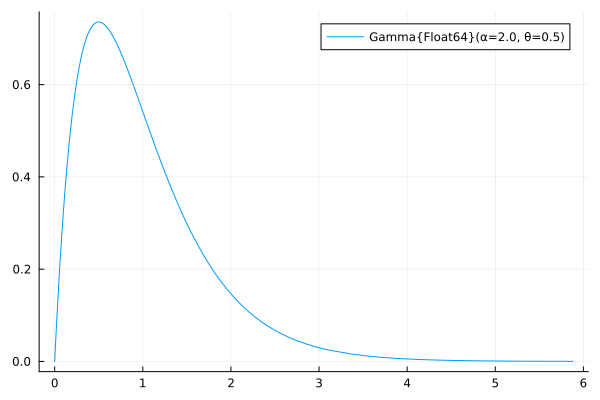

In [6]:
dist = Gamma(2, 1/2)
plot(dist; label="$dist")

In [7]:
quadgk(x -> pdf(dist, x), 0, Inf)

(0.9999999999999994, 5.125997686399427e-10)

In [8]:
f(x) = pdf(dist, x) - pdf(dist, 0.1)
find_zero(f, (0, 0.2))

0.10000000000000002

In [9]:
find_zeros(f, (0, 10))

2-element Vector{Float64}:
 0.1
 1.4301995292318426

In [10]:
@syms x::real, a::positive

(x, a)

In [11]:
sympy.integrate(exp(-x^2/a), (x, -oo, oo))

  ____   ___
\/ pi *\/ a 